# Imports

In [1]:
import kagglehub
import os
import numpy as np
import torch
from torch import nn, optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import v2
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder
import seaborn as sns

In [2]:
# PyTorch setup
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

# Download data

In [3]:
# Download latest version
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

print("Path to dataset files:", path)

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3


In [4]:
path = '/teamspace/studios/this_studio/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset'

In [5]:
os.listdir(path)

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

# Create Dataloaders & Datasets

In [6]:
# data augmentation
image_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomRotation(degrees=5,  expand=True),
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
full_data = ImageFolder(path, transform=image_transforms)
full_data

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: /teamspace/studios/this_studio/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomHorizontalFlip(p=0.25)
                 RandomVerticalFlip(p=0.25)
                 RandomRotation(degrees=[-5.0, 5.0], interpolation=InterpolationMode.NEAREST, expand=True, fill=0)
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [8]:
# splitting of data into 80-10-10 ratio for train, test and validation datasets respectively
train_size = int(0.8*len(full_data))
train_data, test_val_data = random_split(dataset=full_data, lengths=[train_size, len(full_data) - train_size])
test_size = len(test_val_data)//2
test_data, val_data = random_split(dataset=test_val_data, lengths=[test_size, len(test_val_data) - test_size])
len(test_data), len(val_data), len(train_data)

(686, 687, 5489)

In [9]:
# create dataloaders
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [10]:
def show_batch_sample(dataLoader):
    a, b = next(iter(dataLoader))
    a
    b
    grid = make_grid(a)
    show(grid)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
        inv_normalize = v2.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
        imgs = inv_normalize(imgs)
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

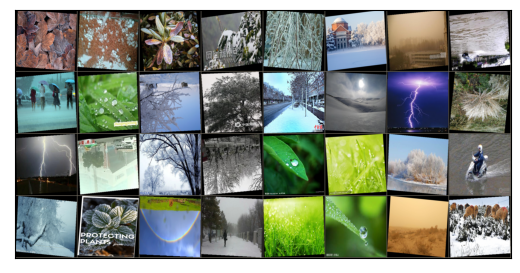

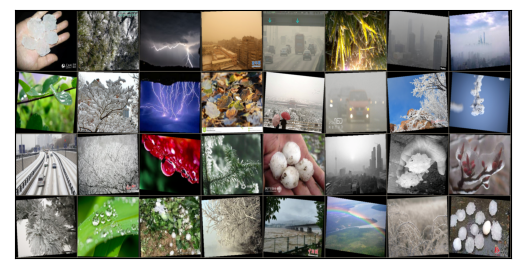

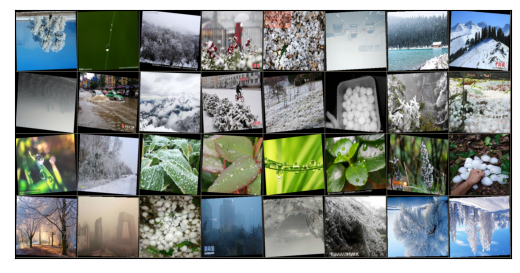

In [11]:
show_batch_sample(train_loader)
show_batch_sample(test_loader)
show_batch_sample(val_loader)

# Create the model

In [12]:
# max-norm weight constraint wrapper around nn.Conv2d

class ConstrainedConv2d(nn.Conv2d):
    def _max_norm(self, w, threshold=4):
        with torch.no_grad():
            norm = w.norm(2, dim=0, keepdim=True).clamp(min=threshold / 2)
            desired = torch.clamp(norm, max=threshold)
            return w * (desired / norm)
    
    def forward(self, input):
        return self._conv_forward(input, self._max_norm(self.weight), self.bias)

In [13]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, channels_in, channels_out, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.downsample = downsample

        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(channels_in, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels_in, channels_out, kernel_size=1, bias=False)
        )

        self.conv2 = nn.Sequential(
            nn.BatchNorm2d(channels_out, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=stride, padding=1, bias=False)
        )

        self.conv3 = nn.Sequential(
            nn.BatchNorm2d(channels_out, momentum=0.9),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels_out, channels_out * self.expansion, kernel_size=1, bias=False)
        )

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        out += identity
        # out = nn.ReLU(inplace=True)(out)
        return out

In [14]:
def _resnet_stem(*layer_sizes):
    out = []
    for i in range (len(layer_sizes)-1):
        out += [
                    nn.Conv2d(layer_sizes[i], layer_sizes[i+1], 3, stride=2 if i==0 else 1, padding=1, bias=False),
                    nn.BatchNorm2d(layer_sizes[i+1]),
                    nn.ReLU(inplace=True)
               ]
    out += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
    return (nn.Sequential(*out))

In [15]:
_resnet_stem(3,32,32,64)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, layers, classes=11):
        super(ResNet, self).__init__()
        self.channels_in = 64
        
        self.stem = _resnet_stem(3,32,32,64)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.final = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512 * block.expansion, classes)
        )

    def _make_layer(self, block, channels_out, block_count, stride=1):
        downsample = None
        if stride != 1 or self.channels_in != channels_out * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.channels_in, channels_out * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels_out * block.expansion, momentum=0.9)
            )
            
        layers = [block(self.channels_in, channels_out, stride, downsample)]
        self.channels_in = channels_out * block.expansion
        layers += [block(self.channels_in, channels_out) for _ in range(1, block_count)]
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.final(x)
        return x

In [17]:
ResNet52 = ResNet(Bottleneck, [3, 4, 6, 3], classes=11)
summary(ResNet52, (1, 3, 224, 224), depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 11]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 112, 112]         64
│    └─ReLU: 2-3                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         18,432
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └

# Train the model

In [38]:
max_lr = 1e-4
min_lr = 8e-6
cycle_length = 7
cycle_count = 2
optimizer = optim.RAdam(ResNet52.parameters(), lr=max_lr, weight_decay=0.1, decoupled_weight_decay=True)
loss_func = nn.CrossEntropyLoss()

In [39]:
# ?? lr_finder.range_test

In [ ]:
lr_finder = LRFinder(ResNet52, optimizer, loss_func, device=device)
lr_finder.range_test(train_loader, val_loader=val_loader, start_lr=1e-4, end_lr=1, num_iter=100, step_mode="exp", diverge_th=20)
lr_finder.plot()
lr_finder.reset()

In [41]:
scheduler1 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cycle_length, eta_min=min_lr)
scheduler2 = lr_scheduler.LambdaLR(optimizer, lr_lambda=(lambda a: min_lr/max_lr))
sequence = [scheduler1 for _ in range(cycle_count)] + [scheduler2]
milestones = [i * (cycle_length + 1) for i in range (1, cycle_count + 1)]
scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=sequence, milestones=milestones)

In [42]:
# early stopping class

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [43]:
epochs = 50
early_stopper = EarlyStopping(patience=8, delta=0)

train_losses = []
val_losses = []

for epoch in range(epochs):
    
    # training phase
    ResNet52.train()
    epoch_train_loss = 0.0
    epoch_train_acc = 0.0
    train_correct = 0
    train_samples = 0
    
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        pred = ResNet52(image)
        train_loss = loss_func(pred, label)

        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item() * image.size(0)
        train_correct += (torch.argmax(pred, dim=1) == label).sum().item()
        train_samples += label.size(0)

    scheduler.step()
    epoch_lr = scheduler.get_last_lr()[0]

    epoch_train_loss /= len(train_loader.dataset)
    epoch_train_acc = 100 * train_correct / train_samples
    train_losses.append(epoch_train_loss)

    # validation phase
    ResNet52.eval()
    epoch_val_loss = 0.0
    epoch_val_acc = 0.0
    val_correct = 0
    val_samples = 0
    with torch.inference_mode():
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)

            pred = ResNet52(image)
            val_loss = loss_func(pred, label)
            epoch_val_loss += val_loss.item() * image.size(0)
            val_correct += (torch.argmax(pred, dim=1) == label).sum().item()
            val_samples += label.size(0)

        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct / val_samples
        val_losses.append(epoch_val_loss)

    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f},\
    Training Accuracy: {epoch_train_acc:.4f}, Validation Accuracy: {epoch_val_acc:.4f}, Learning Rate: {epoch_lr:.3e}")

    # Early stopping
    early_stopper(epoch_val_loss, ResNet52)
    if early_stopper.early_stop:
        print("Early stopping")
        break
    

Epoch: 1/50, Training Loss: 0.6325, Validation Loss: 0.7915,    Training Accuracy: 78.2292, Validation Accuracy: 75.6914, Learning Rate: 1.157e-04
Epoch: 2/50, Training Loss: 0.7003, Validation Loss: 0.8626,    Training Accuracy: 74.8406, Validation Accuracy: 73.6536, Learning Rate: 1.104e-04
Epoch: 3/50, Training Loss: 0.6897, Validation Loss: 0.8767,    Training Accuracy: 75.7879, Validation Accuracy: 72.3435, Learning Rate: 9.544e-05
Epoch: 4/50, Training Loss: 0.6662, Validation Loss: 0.8558,    Training Accuracy: 77.2090, Validation Accuracy: 73.0713, Learning Rate: 7.385e-05
Epoch: 5/50, Training Loss: 0.6398, Validation Loss: 0.8335,    Training Accuracy: 78.0652, Validation Accuracy: 71.7613, Learning Rate: 4.988e-05
Epoch: 6/50, Training Loss: 0.5856, Validation Loss: 0.8973,    Training Accuracy: 79.1765, Validation Accuracy: 74.2358, Learning Rate: 2.828e-05
Epoch: 7/50, Training Loss: 0.5202, Validation Loss: 0.6878,    Training Accuracy: 81.5085, Validation Accuracy: 79.91

In [49]:
early_stopper.load_best_model(ResNet52)

# Visualize loss

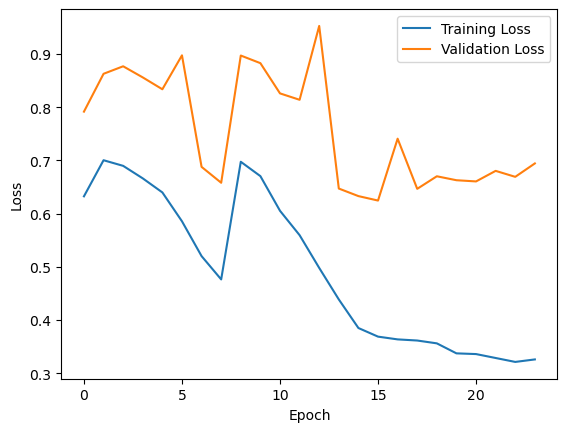

In [50]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test Model

In [51]:
predicted_labels = []
actual_labels = []

ResNet52.eval()
with torch.inference_mode():
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        outputs = ResNet52(image)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(label.cpu().numpy())

Model Accuracy: 79.74%
Model Precision: 82.08%
Model Recall: 79.74%
Model F1 Score: 79.95%
              precision    recall  f1-score   support

           0       0.98      0.72      0.83        76
           1       0.91      0.89      0.90        87
           2       0.76      0.68      0.72        57
           3       0.74      0.55      0.63        71
           4       0.63      0.95      0.76        64
           5       0.89      0.98      0.93        41
           6       0.86      0.73      0.79        49
           7       0.81      0.76      0.79        17
           8       0.89      0.82      0.85       114
           9       0.92      0.89      0.91        54
          10       0.54      0.80      0.65        56

    accuracy                           0.80       686
   macro avg       0.81      0.80      0.80       686
weighted avg       0.82      0.80      0.80       686



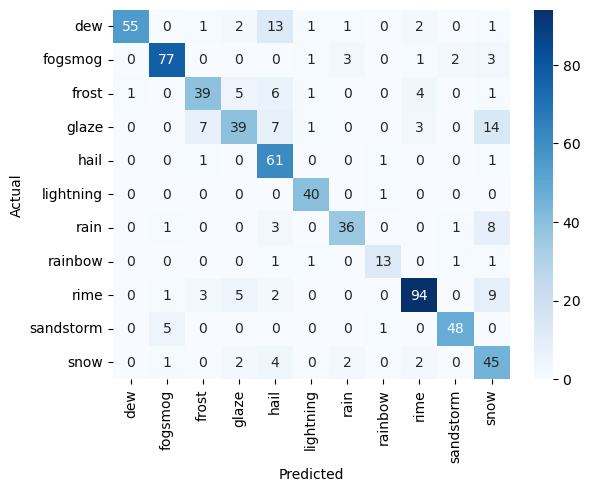

In [52]:
# print model accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# print precision

precision = precision_score(actual_labels, predicted_labels, average='weighted')
print(f"Model Precision: {precision * 100:.2f}%")

# print recall

recall = recall_score(actual_labels, predicted_labels, average='weighted')
print(f"Model Recall: {recall * 100:.2f}%")

# print f1 score

f1 = f1_score(actual_labels, predicted_labels, average='weighted')
print(f"Model F1 Score: {f1 * 100:.2f}%")

# print classification report

print(classification_report(actual_labels, predicted_labels))

# get confsion matrix and print actual labels

cm = confusion_matrix(actual_labels, predicted_labels)

class_names = full_data.classes
# visualize confusion matruix using sns
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save Model

In [53]:
# save model
torch.save(ResNet52.state_dict(), 'resnet52.pth')